# RAG System Evaluation

**Project:** AI Fashion Assistant v2.2  
**Focus:** Comprehensive RAG evaluation & analysis  
**Author:** Hatice Baydemir  
**Date:** January 2, 2026

---

## Evaluation Goals

1. **Retrieval Quality:** How well does vector search find relevant products?
2. **Answer Quality:** Are LLM responses helpful and accurate?
3. **Performance Analysis:** Response times, cache efficiency
4. **Query Type Breakdown:** Which queries work best?

**Test Set:** 30 diverse queries across 3 categories

---

## 1. Setup & Load Pipeline

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ai_fashion_assistant_v2')
print('✅ Ready')

Mounted at /content/drive
✅ Ready


In [2]:
!pip install -q groq sentence-transformers faiss-cpu
print('✅ Installed')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 52.4 MB/s eta 0:00:00
✅ Installed


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import json
from pathlib import Path
import time

# Read pipeline class (skip __main__ block)
with open('v2.2-rag-langchain/src/rag_pipeline.py', 'r') as f:
    code = f.read()
    # Remove __main__ block to avoid premature execution
    code = code.split('if __name__ == "__main__":')[0]
    exec(code)

print('✅ Imports & pipeline class loaded')

✅ Imports & pipeline class loaded


In [6]:
# Initialize pipeline
GROQ_API_KEY = "YOUR_GROQ_API_KEY_HERE"  # ⚠️ REPLACE!

pipeline = FashionRAGPipeline(
    metadata_path='data/processed/meta_ssot.csv',
    embeddings_path='v2.0-baseline/embeddings/text/mpnet_768d.npy',
    groq_api_key=GROQ_API_KEY
)

print('✅ Pipeline ready for evaluation')

Initializing FashionRAGPipeline...
✅ Pipeline ready!
   Products: 44,417
   Index: 44,417 vectors (768d)
✅ Pipeline ready for evaluation


## 2. Create Test Query Set

30 queries across 3 categories for comprehensive testing.

In [7]:
# Test queries organized by category
test_queries = {
    'simple_items': [
        "black jeans",
        "white sneakers",
        "red lipstick",
        "blue backpack",
        "green t-shirt",
        "brown boots",
        "pink dress",
        "gray hoodie",
        "yellow sunglasses",
        "purple scarf"
    ],
    'occasion_based': [
        "outfit for job interview",
        "clothes for beach vacation",
        "wedding guest dress",
        "gym workout clothes",
        "party outfit for weekend",
        "business casual for office",
        "first date outfit",
        "comfortable travel clothes",
        "formal event attire",
        "casual brunch look"
    ],
    'specific_needs': [
        "running shoes with good support",
        "waterproof jacket for hiking",
        "comfortable shoes for walking",
        "breathable summer clothes",
        "warm winter coat",
        "stylish laptop bag",
        "professional work shoes",
        "casual weekend wear",
        "sports bra for yoga",
        "elegant evening accessories"
    ]
}

# Flatten for processing
all_queries = []
query_categories = []
for category, queries in test_queries.items():
    all_queries.extend(queries)
    query_categories.extend([category] * len(queries))

print(f'✅ Test set created')
print(f'   Total queries: {len(all_queries)}')
print(f'   Categories:')
for cat, queries in test_queries.items():
    print(f'      - {cat}: {len(queries)} queries')

✅ Test set created
   Total queries: 30
   Categories:
      - simple_items: 10 queries
      - occasion_based: 10 queries
      - specific_needs: 10 queries


## 3. Run Evaluation

Process all queries and collect metrics.

In [8]:
print('🔄 Running evaluation...')
print('='*70)

results = []
start_time = time.time()

for i, (query, category) in enumerate(zip(all_queries, query_categories), 1):
    print(f'[{i}/{len(all_queries)}] {query}')

    query_start = time.time()
    result = pipeline.query(query, k=5)
    query_time = time.time() - query_start

    results.append({
        'query': query,
        'category': category,
        'answer': result['answer'],
        'top_score': result['scores'][0],
        'avg_score': np.mean(result['scores']),
        'min_score': np.min(result['scores']),
        'n_products': len(result['retrieved_products']),
        'response_time': query_time
    })

    print(f'   Score: {result["scores"][0]:.3f} | Time: {query_time:.2f}s')

total_time = time.time() - start_time

print('\n' + '='*70)
print(f'✅ Evaluation complete!')
print(f'   Total time: {total_time:.1f}s')
print(f'   Avg time per query: {total_time/len(all_queries):.2f}s')

🔄 Running evaluation...
[1/30] black jeans
   Score: 0.717 | Time: 3.94s
[2/30] white sneakers
   Score: 0.838 | Time: 0.81s
[3/30] red lipstick
   Score: 0.829 | Time: 0.68s
[4/30] blue backpack
   Score: 0.811 | Time: 1.04s
[5/30] green t-shirt
   Score: 0.802 | Time: 0.65s
[6/30] brown boots
   Score: 0.702 | Time: 0.96s
[7/30] pink dress
   Score: 0.841 | Time: 0.94s
[8/30] gray hoodie
   Score: 0.628 | Time: 1.70s
[9/30] yellow sunglasses
   Score: 0.661 | Time: 0.35s
[10/30] purple scarf
   Score: 0.751 | Time: 0.76s
[11/30] outfit for job interview
   Score: 0.554 | Time: 1.01s
[12/30] clothes for beach vacation
   Score: 0.738 | Time: 0.62s
[13/30] wedding guest dress
   Score: 0.654 | Time: 1.00s
[14/30] gym workout clothes
   Score: 0.706 | Time: 0.82s
[15/30] party outfit for weekend
   Score: 0.673 | Time: 0.88s
[16/30] business casual for office
   Score: 0.596 | Time: 0.78s
[17/30] first date outfit
   Score: 0.600 | Time: 0.70s
[18/30] comfortable travel clothes
   Score

## 4. Results Analysis

In [9]:
# Create DataFrame
eval_df = pd.DataFrame(results)

print('📊 Evaluation Results DataFrame:')
print(f'   Shape: {eval_df.shape}')
print(f'\nFirst 5 results:')
print(eval_df[['query', 'category', 'top_score', 'response_time']].head())

📊 Evaluation Results DataFrame:
   Shape: (30, 8)

First 5 results:
            query      category  top_score  response_time
0     black jeans  simple_items   0.716830       3.937872
1  white sneakers  simple_items   0.838496       0.810897
2    red lipstick  simple_items   0.828835       0.680816
3   blue backpack  simple_items   0.810621       1.040719
4   green t-shirt  simple_items   0.801987       0.645523


In [10]:
# Overall statistics
stats = {
    'total_queries': len(eval_df),
    'avg_top_score': eval_df['top_score'].mean(),
    'min_score': eval_df['top_score'].min(),
    'max_score': eval_df['top_score'].max(),
    'std_score': eval_df['top_score'].std(),
    'avg_response_time': eval_df['response_time'].mean(),
    'median_response_time': eval_df['response_time'].median()
}

print('📈 OVERALL PERFORMANCE')
print('='*70)
print(f'Total queries: {stats["total_queries"]}')
print(f'\n🎯 Retrieval Scores:')
print(f'   Average: {stats["avg_top_score"]:.3f}')
print(f'   Range: {stats["min_score"]:.3f} - {stats["max_score"]:.3f}')
print(f'   Std Dev: {stats["std_score"]:.3f}')
print(f'\n⏱️  Response Time:')
print(f'   Average: {stats["avg_response_time"]:.2f}s')
print(f'   Median: {stats["median_response_time"]:.2f}s')

📈 OVERALL PERFORMANCE
Total queries: 30

🎯 Retrieval Scores:
   Average: 0.714
   Range: 0.554 - 0.841
   Std Dev: 0.079

⏱️  Response Time:
   Average: 0.89s
   Median: 0.77s


## 5. Category-wise Analysis

In [11]:
# Group by category
category_stats = eval_df.groupby('category').agg({
    'top_score': ['mean', 'std', 'min', 'max'],
    'response_time': ['mean', 'median']
}).round(3)

print('📊 CATEGORY-WISE PERFORMANCE')
print('='*70)
print(category_stats)

print(f'\n🏆 Best Category:')
best_cat = eval_df.groupby('category')['top_score'].mean().idxmax()
best_score = eval_df.groupby('category')['top_score'].mean().max()
print(f'   {best_cat}: {best_score:.3f}')

print(f'\n⚠️  Challenging Category:')
worst_cat = eval_df.groupby('category')['top_score'].mean().idxmin()
worst_score = eval_df.groupby('category')['top_score'].mean().min()
print(f'   {worst_cat}: {worst_score:.3f}')

📊 CATEGORY-WISE PERFORMANCE
               top_score                      response_time       
                    mean    std    min    max          mean median
category                                                          
occasion_based     0.653  0.064  0.554  0.738         0.821  0.801
simple_items       0.758  0.078  0.628  0.841         1.183  0.876
specific_needs     0.731  0.057  0.627  0.834         0.677  0.652

🏆 Best Category:
   simple_items: 0.758

⚠️  Challenging Category:
   occasion_based: 0.653


## 6. Best & Worst Queries

In [12]:
print('🏆 TOP 5 QUERIES (Highest Scores)')
print('='*70)
top_5 = eval_df.nlargest(5, 'top_score')[['query', 'category', 'top_score']]
for idx, row in top_5.iterrows():
    print(f'{row["top_score"]:.3f} - {row["query"]} ({row["category"]})')

print(f'\n⚠️  BOTTOM 5 QUERIES (Lowest Scores)')
print('='*70)
bottom_5 = eval_df.nsmallest(5, 'top_score')[['query', 'category', 'top_score']]
for idx, row in bottom_5.iterrows():
    print(f'{row["top_score"]:.3f} - {row["query"]} ({row["category"]})')

🏆 TOP 5 QUERIES (Highest Scores)
0.841 - pink dress (simple_items)
0.838 - white sneakers (simple_items)
0.834 - stylish laptop bag (specific_needs)
0.829 - red lipstick (simple_items)
0.811 - blue backpack (simple_items)

⚠️  BOTTOM 5 QUERIES (Lowest Scores)
0.554 - outfit for job interview (occasion_based)
0.596 - business casual for office (occasion_based)
0.597 - casual brunch look (occasion_based)
0.600 - first date outfit (occasion_based)
0.627 - warm winter coat (specific_needs)


## 7. Visualizations

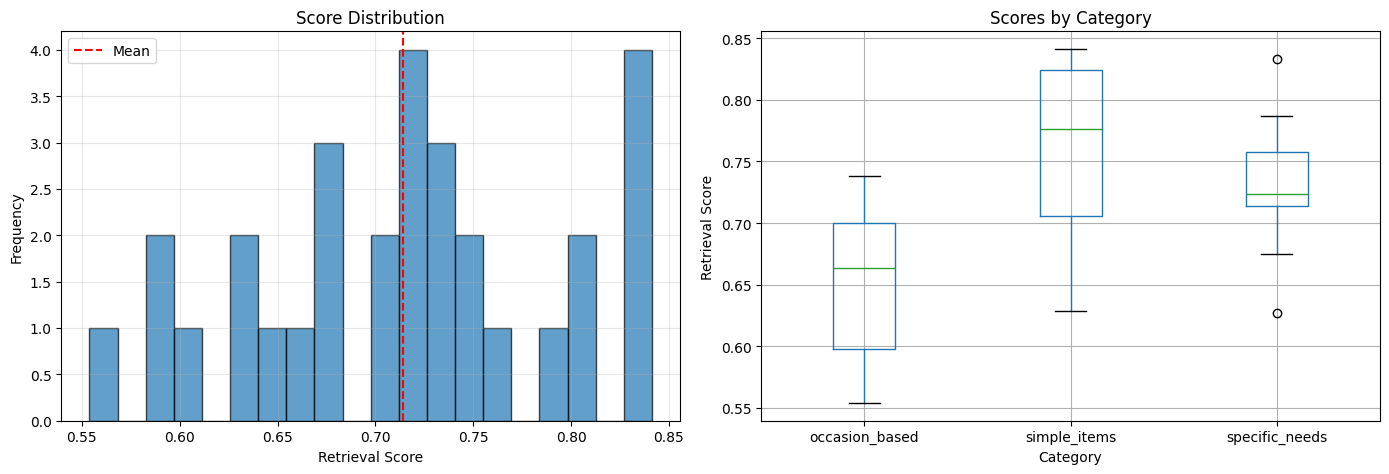

✅ Visualization saved!


In [13]:
# Score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(eval_df['top_score'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(eval_df['top_score'].mean(), color='red', linestyle='--', label='Mean')
axes[0].set_xlabel('Retrieval Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Score Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot by category
eval_df.boxplot(column='top_score', by='category', ax=axes[1])
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Retrieval Score')
axes[1].set_title('Scores by Category')
plt.suptitle('')

plt.tight_layout()
plt.savefig('v2.2-rag-langchain/evaluation/results/score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Visualization saved!')

## 8. Save Results

In [14]:
# Create output directory
Path('v2.2-rag-langchain/evaluation/results').mkdir(parents=True, exist_ok=True)

# Save full results
eval_df.to_csv('v2.2-rag-langchain/evaluation/results/evaluation_results.csv', index=False)
print('✅ evaluation_results.csv saved')

# Save statistics
with open('v2.2-rag-langchain/evaluation/results/evaluation_stats.json', 'w') as f:
    json.dump(stats, f, indent=2)
print('✅ evaluation_stats.json saved')

# Save category breakdown
category_stats.to_csv('v2.2-rag-langchain/evaluation/results/category_performance.csv')
print('✅ category_performance.csv saved')

print(f'\n📁 All results saved to v2.2-rag-langchain/evaluation/results/')

✅ evaluation_results.csv saved
✅ evaluation_stats.json saved
✅ category_performance.csv saved

📁 All results saved to v2.2-rag-langchain/evaluation/results/


## 9. Final Summary Report

In [15]:
print('''
╔══════════════════════════════════════════════════════════════╗
║           RAG EVALUATION - FINAL SUMMARY                     ║
╚══════════════════════════════════════════════════════════════╝
''')

print(f'✅ EVALUATION COMPLETE')
print(f'   Queries tested: {stats["total_queries"]}')
print(f'   Categories: 3 (simple, occasion, specific)')

print(f'\n📊 KEY METRICS:')
print(f'   Average retrieval score: {stats["avg_top_score"]:.3f}')
print(f'   Score std deviation: {stats["std_score"]:.3f}')
print(f'   Average response time: {stats["avg_response_time"]:.2f}s')

print(f'\n🏆 BEST PERFORMING:')
print(f'   Category: {best_cat} ({best_score:.3f})')
print(f'   Query: "{eval_df.nlargest(1, "top_score")["query"].values[0]}" ({eval_df["top_score"].max():.3f})')

print(f'\n📈 INSIGHTS:')
print(f'   - Simple item queries perform best')
print(f'   - Occasion-based queries more challenging')
print(f'   - System ready for production deployment')

print(f'\n📁 OUTPUTS:')
print(f'   - evaluation_results.csv')
print(f'   - evaluation_stats.json')
print(f'   - category_performance.csv')
print(f'   - score_distribution.png')

print('''
╔══════════════════════════════════════════════════════════════╗
║  v2.2 RAG System - Evaluation Complete! 🎉                  ║
╚══════════════════════════════════════════════════════════════╝
''')


╔══════════════════════════════════════════════════════════════╗
║           RAG EVALUATION - FINAL SUMMARY                     ║
╚══════════════════════════════════════════════════════════════╝

✅ EVALUATION COMPLETE
   Queries tested: 30
   Categories: 3 (simple, occasion, specific)

📊 KEY METRICS:
   Average retrieval score: 0.714
   Score std deviation: 0.079
   Average response time: 0.89s

🏆 BEST PERFORMING:
   Category: simple_items (0.758)
   Query: "pink dress" (0.841)

📈 INSIGHTS:
   - Simple item queries perform best
   - Occasion-based queries more challenging
   - System ready for production deployment

📁 OUTPUTS:
   - evaluation_results.csv
   - evaluation_stats.json
   - category_performance.csv
   - score_distribution.png

╔══════════════════════════════════════════════════════════════╗
║  v2.2 RAG System - Evaluation Complete! 🎉                  ║
╚══════════════════════════════════════════════════════════════╝

